# **Mount to Drive to retrieve data**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Load and preprocess data**

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
train_data = torchvision.datasets.ImageFolder(
    'gdrive/MyDrive/Datasets/RiceLeafs/train',
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.486, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
)

In [5]:
validation_data = torchvision.datasets.ImageFolder(
    'gdrive/MyDrive/Datasets/RiceLeafs/validation',
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.486, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
)

In [6]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size = 32,
    shuffle = True,
    num_workers = 2,
    pin_memory = True,
)

In [7]:
validation_loader = torch.utils.data.DataLoader(
    validation_data,
    batch_size = 32,
    shuffle = True,
    num_workers = 2,
    pin_memory = True,
)

# **Model**

In [23]:
class Classifier(nn.Module):
  def init_weights(self, layer):
    if isinstance(layer, nn.Conv2d):
      nn.init.kaiming_normal_(layer.weight)

  def __init__(self):
    super().__init__()

    self.vgg_block_1 = nn.Sequential(
        nn.Conv2d(3, 16, (3, 3), padding = 'same'),
        nn.BatchNorm2d(16),
        nn.ReLU(),
    )

    self.vgg_block_2 = nn.Sequential(
        nn.Conv2d(16, 32, (3, 3), padding = 'same'),
        nn.BatchNorm2d(32),
        nn.ReLU(),
    )

    self.vgg_block_3 = nn.Sequential(
      nn.Conv2d(32, 64, (3, 3), padding = 'same'),
      nn.BatchNorm2d(64),
      nn.ReLU(),
    )

    self.vgg_block_1.apply(self.init_weights)
    self.vgg_block_2.apply(self.init_weights)
    self.vgg_block_3.apply(self.init_weights)

    self.maxpool = nn.MaxPool2d((2, 2), stride = 2)
    self.dropout = nn.Dropout(0.5)

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(64 * 28 * 28, 64)
    nn.init.kaiming_normal_(self.fc1.weight)
    self.bn1 = nn.BatchNorm1d(64)
    self.a1 = nn.ReLU()

    self.fc2 = nn.Linear(64, 4)
    nn.init.xavier_normal_(self.fc2.weight)
    self.bn2 = nn.BatchNorm1d(4)
    self.softmax = nn.Softmax(dim = 1)

  def forward(self, x):
    x = self.vgg_block_1(x)
    x = self.maxpool(x)
    if self.training:
      x = self.dropout(x)

    x = self.vgg_block_2(x)
    x = self.maxpool(x)
    if self.training:
      x = self.dropout(x)

    x = self.vgg_block_3(x)
    x = self.maxpool(x)
    if self.training:
      x = self.dropout(x)
  
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.bn1(x)
    x = self.a1(x)
    if self.training:
      x = self.dropout(x)

    x = self.fc2(x)
    x = self.bn2(x)
    x = self.softmax(x)
    return x

In [24]:
model = Classifier()
model.to(device)

Classifier(
  (vgg_block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (vgg_block_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (vgg_block_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=50176, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a1): ReLU()
  (fc2)

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-4)
epochs = 20

In [27]:
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [28]:
for epoch in range(epochs):
  model.train()
  train_loss = 0
  correct, total = 0, 0

  for images, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(images.to(device))
    loss = criterion(outputs, labels.to(device))
    loss.backward()
    nn.utils.clip_grad_value_(model.parameters(), 0.5)
    optimizer.step()

    train_loss += loss.item()
    total += len(labels.to(device))
    correct += (outputs.argmax(dim = 1) == labels.to(device)).to(torch.int32).sum().item()

  train_loss /= total
  accuracy = correct / total

  val_loss = 0
  correct, total = 0, 0

  with torch.no_grad():
    model.eval()
    for images, labels in validation_loader:
      outputs = model(images.to(device))
      loss = criterion(outputs, labels.to(device))
      
      val_loss += loss.item()
      total += len(labels.to(device))
      correct += (outputs.argmax(dim = 1) == labels.to(device)).to(torch.int32).sum().item()

  val_loss /= total
  val_accuracy = correct / total

  train_loss_list.append(train_loss)
  train_accuracy_list.append(accuracy)
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)

  print('Epoch %d - loss: %.4f - accuracy: %.4f - val_loss: %.4f - val_accuracy: %.4f' % (epoch + 1, train_loss, accuracy, val_loss, val_accuracy))

Epoch 1 - loss: 0.0400 - accuracy: 0.4814 - val_loss: 0.0424 - val_accuracy: 0.2638
Epoch 2 - loss: 0.0386 - accuracy: 0.5499 - val_loss: 0.0429 - val_accuracy: 0.2504
Epoch 3 - loss: 0.0381 - accuracy: 0.5771 - val_loss: 0.0423 - val_accuracy: 0.2966
Epoch 4 - loss: 0.0376 - accuracy: 0.5879 - val_loss: 0.0420 - val_accuracy: 0.3502
Epoch 5 - loss: 0.0372 - accuracy: 0.6028 - val_loss: 0.0419 - val_accuracy: 0.3487
Epoch 6 - loss: 0.0370 - accuracy: 0.6140 - val_loss: 0.0415 - val_accuracy: 0.3949
Epoch 7 - loss: 0.0368 - accuracy: 0.6118 - val_loss: 0.0422 - val_accuracy: 0.3487
Epoch 8 - loss: 0.0366 - accuracy: 0.6095 - val_loss: 0.0424 - val_accuracy: 0.3368
Epoch 9 - loss: 0.0364 - accuracy: 0.6140 - val_loss: 0.0423 - val_accuracy: 0.3666
Epoch 10 - loss: 0.0362 - accuracy: 0.6215 - val_loss: 0.0421 - val_accuracy: 0.3696
Epoch 11 - loss: 0.0359 - accuracy: 0.6226 - val_loss: 0.0419 - val_accuracy: 0.3592
Epoch 12 - loss: 0.0358 - accuracy: 0.6237 - val_loss: 0.0437 - val_accura

In [29]:
torch.save(model.state_dict(), 'model.pth')

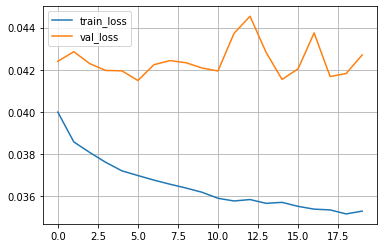

In [32]:
plt.plot(train_loss_list, label = 'train_loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.legend()
plt.grid(True)

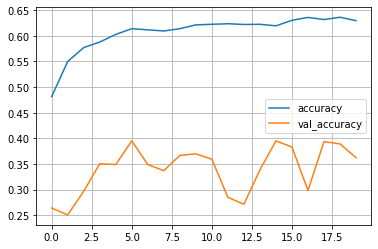

In [33]:
plt.plot(train_accuracy_list, label = 'accuracy')
plt.plot(val_accuracy_list, label = 'val_accuracy')
plt.legend()
plt.grid(True)